Enter the stock name (e.g., CSX): YY


C:\Windows\Temp\ipykernel_5684\1664989104.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])


Enter the date for prediction (YYYY-MM-DD): 2024-11-25
Using the exact available date: 2024-11-25 for prediction.


C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model: dnn_lstm
Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0364 - val_loss: 2.4782e-04
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0060 - val_loss: 1.5493e-04
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0047 - val_loss: 1.4570e-04
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0043 - val_loss: 1.5597e-04
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0043 - val_loss: 1.2598e-04
Epoch 6/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0038 - val_loss: 2.1907e-04
Epoch 7/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0036 - val_loss: 4.6445e-04
Epoch 8/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0033 - val_loss: 2.6696e-04
Epoch 9/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0034 - val_loss: 2.3011e-04
Epoch 10/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0030 - val_loss: 1.3694e-04
Epoch 11/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0031 - val_loss: 2.689

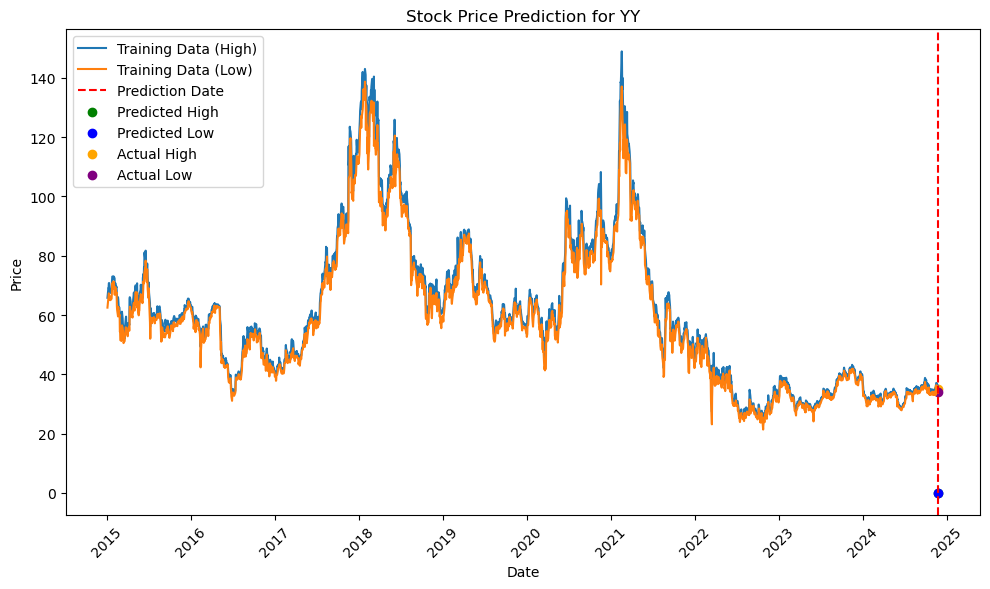

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Function to preprocess the stock data
def preprocess_stock_data(file_path, stock_name):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Standardize stock name and user input
    df['stockname'] = df['stockname'].str.strip().str.upper()
    stock_name = stock_name.strip().upper()
    
    # Filter for the selected stock
    filtered_df = df[df['stockname'] == stock_name]
    if filtered_df.empty:
        raise ValueError(f"No data found for the stock '{stock_name}'. Please check the name.")
    
    # Convert timestamp to datetime
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
    
    # Sort by date
    filtered_df = filtered_df.sort_values(by='timestamp')
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    numeric_cols = filtered_df.select_dtypes(include=['float64', 'int64']).columns
    filtered_df[numeric_cols] = imputer.fit_transform(filtered_df[numeric_cols])
    
    # Add technical indicators
    filtered_df['moving_average'] = filtered_df['high'].rolling(window=5).mean()
    filtered_df['std_dev'] = filtered_df['high'].rolling(window=5).std()
    filtered_df.fillna(method='bfill', inplace=True)  # Fill remaining NaN values
    
    return filtered_df

# Function to prepare data for LSTM
def prepare_lstm_data(df, lookback=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['high', 'low', 'moving_average', 'std_dev']])
    
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])  # Include multiple features
        y.append(scaled_data[i, [0, 1]])  # Targets are 'high' (target high) and 'low' (target low)
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Function to create the DNN + LSTM model
def create_dnn_lstm_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2)  # Output layer for 'high' and 'low'
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Function to create the CNN + LSTM model
def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2)  # Output layer for 'high' and 'low'
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Function to create the GRU + LSTM model
def create_gru_lstm_model(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2)  # Output layer for 'high' and 'low'
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Find the exact available date for prediction
def find_exact_date(df, target_date):
    target_date = pd.to_datetime(target_date).normalize()
    if target_date in df['timestamp'].dt.normalize().values:
        return target_date
    else:
        raise ValueError(f"No data available for the exact date {target_date.date()}.")

if __name__ == "__main__":
    # User input for stock name
    stock_name = input("Enter the stock name (e.g., CSX): ")
    
    # Preprocess the data
    data = preprocess_stock_data('stocks.csv', stock_name)
    
    # User input for prediction date
    prediction_date = input("Enter the date for prediction (YYYY-MM-DD): ")
    prediction_date = pd.to_datetime(prediction_date).normalize()
    
    try:
        exact_date = find_exact_date(data, prediction_date)
        print(f"Using the exact available date: {exact_date.date()} for prediction.")
    except ValueError as e:
        print(e)
        exit()
    
    # Filter the data for training
    train_data = data[data['timestamp'] < exact_date]
    test_data = data[data['timestamp'].dt.normalize() == exact_date]
    
    if test_data.empty:
        raise ValueError(f"No data available for the prediction date: {exact_date.date()}")
    
    # Prepare LSTM data
    X_train, y_train, scaler = prepare_lstm_data(train_data, lookback=60)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    
 